### MACHINE LEARNING FOR FINANCIAL MARKETS

TOPIC: IMPROVING TIME SERIES FORECASTING WITH SYNTHETIC DATA

Tools used: LSTM Neural Networks and TimeGAN (specifically introduced for Time Series)

## Proposed Methodology
The methodology is divided into three main parts:

**Part 1: Training an LSTM Neural Network on Real Data**
- Training Phase: Train an LSTM Neural Network using only the original (real) training dataset.
- Prediction and Evaluation: Apply the trained LSTM model to unseen test data to make predictions. Evaluate the model's performance using metrics such as Mean Squared Error (MSE) and Mean Absolute Error (MAE).

**Part 2: Augmenting the Dataset with Synthetic Data and Training a New LSTM Model**
- Synthetic Data Generation: Build and train a TimeGAN (Time-series Generative Adversarial Network) to generate synthetic time-series data. Combine the synthetic data with the original training dataset to create an augmented training dataset.
- Training Phase: Train a new LSTM Neural Network on the augmented training dataset.
- Prediction and Evaluation: Apply the new LSTM model to the same unseen test data to make predictions. Evaluate its performance using the same metrics (MSE and MAE).

**Part 3: Comparison and Analysis**
- Compare the performance of the two LSTM models: The first model, trained only on real data. The second model, trained on the augmented dataset (real + synthetic data) Measure whether the inclusion of synthetic data leads to an improvement in performance.


**Expected Outcomes**
The comparison will reveal whether the augmented dataset (real + synthetic data) leads to better performance compared to using only real data.
If the synthetic data is of high quality and captures the underlying patterns of the real data, the second LSTM model is expected to achieve lower MSE and MAE on the test set.

In [251]:
#Import all the necessary libraries for LSTM and GANs

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #adam is the optimizer we are going to use
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

# STEP 0: Explore the dataset and prepare the sliding window

In [252]:
#load the dataset (data from 02/20/2015 to 02/19/2025)
path = '/Users/francescavasta/Desktop/MSFT historical data.csv'
df = pd.read_csv(path)

df = df[['Date', 'Close/Last']]
df.info()

#we see that we have a problem with the date format because it is a string
#also the stock value is a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [253]:
#handling of ['Date'] values
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month = month, day=day)

#testing the function
#datetime_object = str_to_datetime('02/20/2015')
#datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Close/Last
0,2025-02-19,$414.77
1,2025-02-18,$409.64
2,2025-02-14,$408.43
3,2025-02-13,$410.54
4,2025-02-12,$409.04
...,...,...
2510,2015-02-26,$44.055
2511,2015-02-25,$43.99
2512,2015-02-24,$44.09
2513,2015-02-23,$44.15


In [254]:
#handling of Close/Last values
df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")
df['Close/Last'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [255]:
#we prefer to have our data ordered chronologically from past to future 
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df

,Date,Close/Last
0,2015-02-20,43.855
1,2015-02-23,44.150
2,2015-02-24,44.090
3,2015-02-25,43.990
4,2015-02-26,44.055
...,...,...
2510,2025-02-12,409.040
2511,2025-02-13,410.540
2512,2025-02-14,408.430
2513,2025-02-18,409.640


In [256]:
#now we want to remove the index and make the date itslef as the index
df.index = df.pop('Date')
df

,Close/Last
Date,
2015-02-20,43.855
2015-02-23,44.150
2015-02-24,44.090
2015-02-25,43.990
2015-02-26,44.055
...,...
2025-02-12,409.040
2025-02-13,410.540
2025-02-14,408.430


In [257]:
#The function scrolls the DataFrame and creates time sequences (windows) of past data 
# to predict the future data (target).

def df_to_windowed_df (dataframe, first_date_str,last_date_str, n = 5): 
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X,Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date')
            return
    
        values = df_subset['Close/Last'].to_numpy()
        x, y = values [:-1], values [-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str=str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        # Find the next date
        #next_date = target_date + datetime.timedelta(days=1)  # Assuming the next day is the next target date
        
        #target_date = next_date

        if last_time: 
            break 

        target_date = next_date
        
        if target_date == last_date:
            last_time = True
        

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array (X)
    for i in range (0,n):
        X[:, i]
        ret_df[f'Target - {n-i}'] = X[:, i]
    
    ret_df['Target'] = Y 

    return ret_df    

In [258]:
#apply the function. The start date can't be 20/02/2015 because it must have 5 other dates prior
windowed_df = df_to_windowed_df(df,'02/27/2015', '02/19/2025' ,n = 5)

windowed_df

,Target Date,Target - 5,Target - 4,Target - 3,Target - 2,Target - 1,Target
0,2015-02-27,43.855,44.150,44.090,43.990,44.055,43.850
1,2015-03-02,44.150,44.090,43.990,44.055,43.850,43.880
2,2015-03-03,44.090,43.990,44.055,43.850,43.880,43.280
3,2015-03-04,43.990,44.055,43.850,43.880,43.280,43.055
4,2015-03-05,44.055,43.850,43.880,43.280,43.055,43.110
...,...,...,...,...,...,...,...
2505,2025-02-12,413.290,415.820,409.750,412.220,411.440,409.040
2506,2025-02-13,415.820,409.750,412.220,411.440,409.040,410.540
2507,2025-02-14,409.750,412.220,411.440,409.040,410.540,408.430
2508,2025-02-18,412.220,411.440,409.040,410.540,408.430,409.640


In [259]:
#this function helps us to distinguish the target variable from the predictors
def windowed_df_to_date_X_y (windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix  = df_as_np [:, 1:-1] #to take only the "Target-n" columns
    #middle matrix is not the final input matrix

    X = middle_matrix.reshape((len(dates),middle_matrix.shape[1], 1)) #"1" because it is univariate forecasting
    #if we used also the volume variable, then we would need to change the number

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X_orig, y_orig = windowed_df_to_date_X_y(windowed_df)

dates.shape, X_orig.shape, y_orig.shape

((2510,), (2510, 5, 1), (2510,))

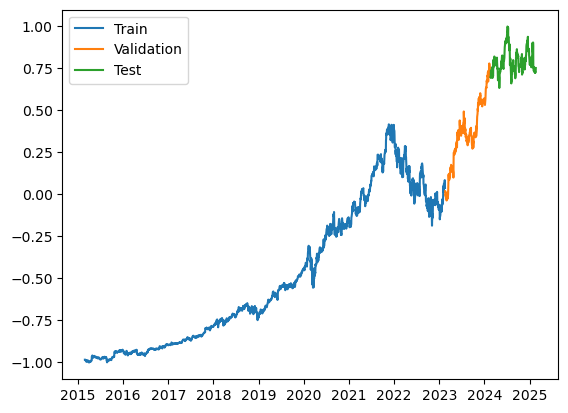

In [260]:
#LSTM performs better when using Standardized data 
#we need to use this range because the TimeGAN will use "tanh", which requires data scaled between -1 and 1.
X_scaler = MinMaxScaler(feature_range=(-1, 1)) 
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the data of "windowed_df"
windowed_df.iloc[:, 1:-1] = X_scaler.fit_transform(windowed_df.iloc[:, 1:-1])  # To standardize X
windowed_df.iloc[:, -1] = y_scaler.fit_transform(windowed_df.iloc[:, -1].values.reshape(-1, 1))  # To standardize y

# We need to apply again the function to obtain dates, X, y
dates, X_norm, y_norm = windowed_df_to_date_X_y(windowed_df)

# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_80 = int(len(dates)*.8)
q_90 = int(len(dates)*.9)

#splitting the standardized dataset
dates_train, X_train_norm, y_train_norm = dates[:q_80], X_norm[:q_80], y_norm[:q_80]
dates_val, X_val_norm, y_val_norm = dates[q_80:q_90], X_norm[q_80:q_90], y_norm[q_80:q_90]
dates_test, X_test_norm, y_test_norm = dates[q_90:], X_norm[q_90:], y_norm[q_90:] #from q_90 onwards

#splitting also the non-standardized dataset for future plots
dates_train, X_train_orig, y_train_orig = dates[:q_80], X_orig[:q_80], y_orig[:q_80]
dates_val, X_val_orig, y_val_orig = dates[q_80:q_90], X_orig[q_80:q_90], y_orig[q_80:q_90]
dates_test, X_test_orig, y_test_orig = dates[q_90:], X_orig[q_90:], y_orig[q_90:] #from q_90 onwards

plt.plot(dates_train, y_train_norm)
plt.plot(dates_val, y_val_norm)
plt.plot(dates_test, y_test_norm)

plt.legend(['Train', 'Validation', 'Test'])

# PART 1: build the LSTM and train it on original data

In [263]:
model = Sequential([layers.Input((5, 1)), # we need to specify the shape of the input
                    layers.LSTM(64), #the higher is this number, the higher is the risk of overfitting
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(32, activation ='tanh'),
                    layers.Dense(1) #by default the output is linear
                    ])

model.compile(loss= tf.keras.losses.Huber(delta=0.1), 
              optimizer=Adam(learning_rate=0.0001),
              metrics = ['mean_absolute_error'])

model.fit(X_train_norm,y_train_norm, validation_data=(X_val_norm, y_val_norm), epochs = 100)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0458 - mean_absolute_error: 0.5055 - val_loss: 0.0332 - val_mean_absolute_error: 0.3820
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - mean_absolute_error: 0.2279 - val_loss: 0.0249 - val_mean_absolute_error: 0.2988
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mean_absolute_error: 0.0730 - val_loss: 0.0094 - val_mean_absolute_error: 0.1419
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0197e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0030 - val_mean_absolute_error: 0.0660
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3469e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0026 - val_mean_absolute_error: 0.0595
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2283e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0024 - val_mean_absolute_error: 0.0569
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2002e-04 - mean_absolute_error: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step

Train Set Performance Metrics:
MAE: $2.28
RMSE: $3.67


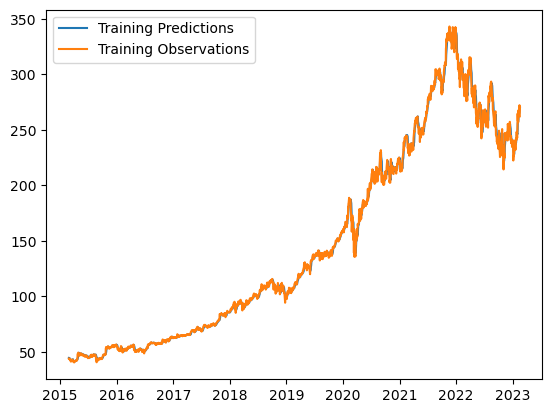

In [265]:
#the model was trained with X_train_norm and y_train_norm, now we use X_train_norm to make training predictions
#then we compare y_train (true) with train predictions
train_predictions_norm = model.predict(X_train_norm).flatten ()
#back to original scale with "inverse_transform" and reshape
train_predictions_orig = y_scaler.inverse_transform(train_predictions_norm.reshape(-1, 1)).flatten()


plt.plot (dates_train, train_predictions_orig) 
plt.plot (dates_train, y_train_orig)
plt. legend (['Training Predictions', 'Training Observations'])

#Performance on training set
mae_train = mean_absolute_error(y_train_orig, train_predictions_orig)
rmse_train = np.sqrt(mean_squared_error(y_train_orig, train_predictions_orig))
               
print("\nTrain Set Performance Metrics:")
print(f"MAE: ${mae_train:.2f}")
print(f"RMSE: ${rmse_train:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Validation Set Performance Metrics:
MAE: $5.59
RMSE: $7.00


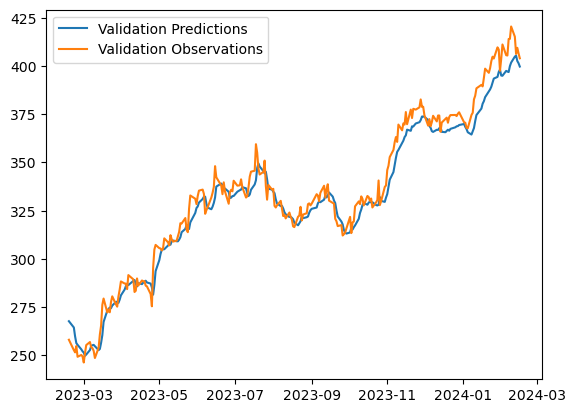

In [266]:
#Now we use X_val to try to predict y_val
val_predictions_norm = model.predict (X_val_norm).flatten () 
val_predictions_orig = y_scaler.inverse_transform(val_predictions_norm.reshape(-1, 1)).flatten()

plt.plot (dates_val, val_predictions_orig) 
plt.plot (dates_val, y_val_orig)
plt. legend(['Validation Predictions', 'Validation Observations'])

#Performance on validation set
mae_val = mean_absolute_error(y_val_orig, val_predictions_orig)
rmse_val = np.sqrt(mean_squared_error(y_val_orig, val_predictions_orig))

print("\nValidation Set Performance Metrics:")
print(f"MAE: ${mae_val:.2f}")
print(f"RMSE: ${rmse_val:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_13904/3743027223.py:17: SyntaxWarning: invalid escape sequence '\T'
  print("\Test Set Performance Metrics:")


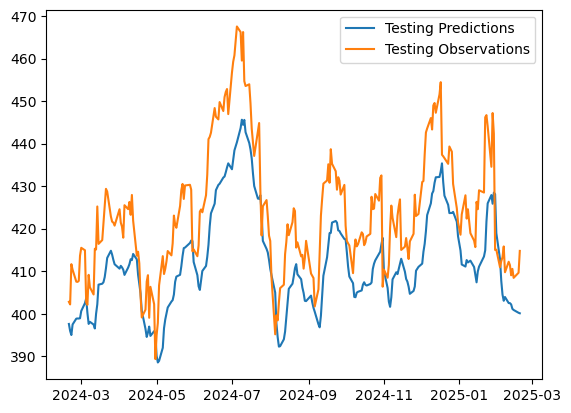

\Test Set Performance Metrics:
MAE: $12.10
RMSE: $13.50


In [267]:
#Finally we use the LSTM model to predict y_test, using X_test. 
#In other words, the model is now fit using data that the model has never seen before.

test_predictions_norm = model.predict(X_test_norm).flatten()
test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1)).flatten()


plt.plot(dates_test, test_predictions_orig, label='Testing Predictions')
plt.plot(dates_test, y_test_orig, label='Testing Observations')
plt.legend()
plt.show()

#Performance on test set
mae_test = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_test = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

print("\Test Set Performance Metrics:")
print(f"MAE: ${mae_test:.2f}")
print(f"RMSE: ${rmse_test:.2f}")

# PART 2: Use TimeGAN to generate synthetic data. Then fit the LSTM on augmented training data.

In [268]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Model, Sequential

class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, batch_size=128):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.build_model()

    def build_model(self):
        # Encoder
        self.encoder = Sequential([
            LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            LSTM(self.hidden_dim, return_sequences=False)
        ])

        # Decoder (Recovery network)
        self.decoder = Sequential([
            Dense(self.hidden_dim, activation='relu'),
            Dense(self.seq_len * self.feature_dim, activation='tanh'),
            tf.keras.layers.Reshape((self.seq_len, self.feature_dim))
        ])

        # Generator
        self.generator = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            Dropout(0.2),
            LSTM(self.hidden_dim * 2, return_sequences=True),
            Dropout(0.2),
            TimeDistributed(Dense(self.hidden_dim, activation='relu')),
            TimeDistributed(Dense(self.feature_dim, activation='tanh'))
        ])

        # Supervisor network
        self.supervisor = Sequential([
            LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_len, self.hidden_dim)),
            LSTM(self.hidden_dim, return_sequences=True)
        ])

        # Discriminator
        self.discriminator = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            LSTM(self.hidden_dim, return_sequences=False),
            Dropout(0.3),
            Dense(self.hidden_dim // 2, activation='relu'),
            Dense(1, activation='sigmoid')
        ])


        # Compile Models
        self.encoder.compile(optimizer='adam', loss='mse')
        self.decoder.compile(optimizer='adam', loss='mse')
        self.generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),loss='mse') 
        self.supervisor.compile(optimizer='adam', loss='mse')
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5), loss='binary_crossentropy')


        # GAN Model (Generator + Discriminator)
        self.discriminator.trainable = False
        gan_input = tf.keras.Input(shape=(self.seq_len, self.feature_dim))
        generated_samples = self.generator(gan_input)
        gan_output = self.discriminator(generated_samples)
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, data, epochs=1000):
        d_losses, g_losses = [], []

        for epoch in range(epochs):
            idx = np.random.randint(0, data.shape[0], self.batch_size)
            real_samples = data[idx]
            noise = np.random.normal(0, 1, (self.batch_size, self.seq_len, self.feature_dim))
            fake_samples = self.generator.predict(noise)

            # Train Discriminator
            real_labels = np.random.uniform(0.9, 1.0, (self.batch_size, 1))
            fake_labels = np.random.uniform(0.0, 0.1, (self.batch_size, 1))
            d_loss_real = self.discriminator.train_on_batch(real_samples, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train Generator
            g_loss = self.gan.train_on_batch(noise, np.ones((self.batch_size, 1)))

            d_losses.append(d_loss)
            g_losses.append(g_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        # Visualizza il grafico delle loss
        plt.figure(figsize=(10, 6))
        plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(g_losses, label='Generator Loss', alpha=0.7)
        plt.title('GAN Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_synthetic_data(self, num_samples, X_scaler, seq_len):
        # Generate synthetic noise
        noise = np.random.normal(0, 1, (num_samples, seq_len, self.feature_dim))
        generated_data = self.generator.predict(noise)
        
        # Reshape generated_data per match con la struttura originale dello scaler
        # Lo scaler è stato applicato su una matrice 2D dove ogni riga conteneva tutti i 5 timestep
        generated_2d = generated_data.reshape(num_samples, seq_len)
        
        # Applica inverse_transform
        generated_denorm = X_scaler.inverse_transform(generated_2d)
        
        # Reshape nel formato finale (num_samples, seq_len, feature_dim)
        generated_final = generated_denorm.reshape(num_samples, seq_len, self.feature_dim)
        
        return generated_final





/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss: 0.6932, G Loss: 0.6932
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

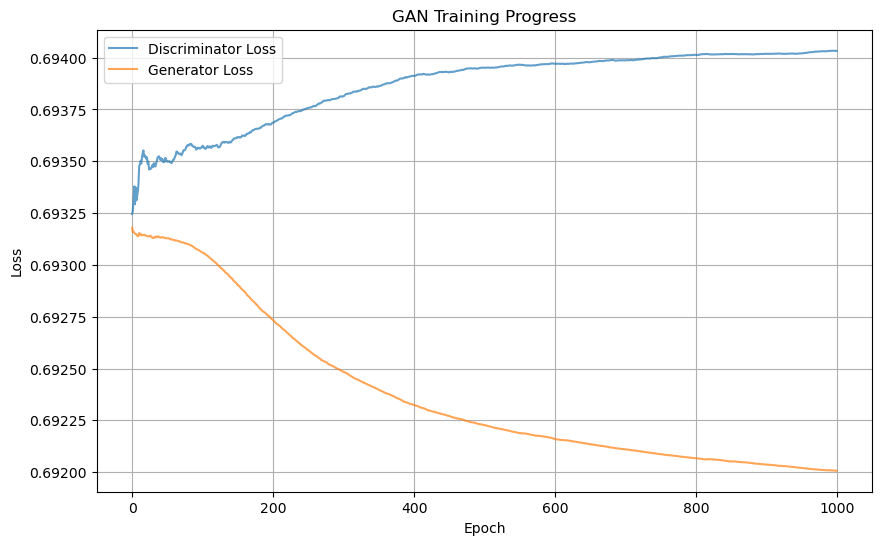

In [269]:
# Training the TimeGAN
seq_len = X_train_norm.shape[1] #output: 5
feature_dim = 1 
timegan = TimeGAN(seq_len, feature_dim)
timegan.train(X_train_norm, epochs=1000)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


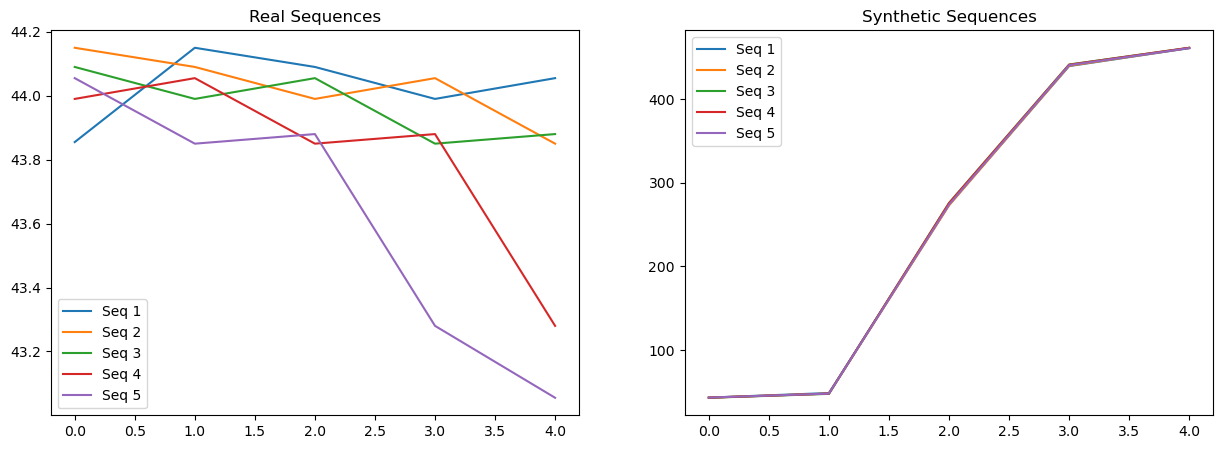

In [ ]:
# 1. Generate based on X_train_norm
num_synthetic = int(X_train_norm.shape[0] * 0.5)  # 50% di dati sintetici
synthetic_sequences = timegan.generate_synthetic_data(num_synthetic, X_scaler,seq_len)

# 2. Use original LSTM trained before to generate synthetic targets 
synthetic_targets = model.predict(synthetic_sequences)
#since our goal is forecasting, we also need to generate synthetic targets using the same LSTM model defined before

# 2. Visualize and compare real sequences and synthetic sequences
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

for i in range(5):
    plt.plot(X_train_orig[i, :, 0], label=f'Seq {i+1}')
plt.title('Real Sequences')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(synthetic_sequences[i, :, 0], label=f'Seq {i+1}')
plt.title('Synthetic Sequences')
plt.legend()
plt.show()



In [287]:
# 3. Combine syntehtic and real
X_train_augmented = np.concatenate([X_train_norm, synthetic_sequences], axis=0)
y_train_augmented = np.concatenate([y_train_norm, synthetic_targets.flatten()], axis=0)

# 4. Shuffle the data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

X_train_augmented
y_train_augmented


array([ 1.4332615 , -0.9207527 , -0.8196925 , ..., -0.26964214,
       -0.84969693,  1.4315817 ], dtype=float32)

In [ ]:
# 5. Train LSTM again with the augmented training dataset
model_augmented = Sequential([
    layers.Input((5, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])

model_augmented.compile(
    loss=tf.keras.losses.Huber(delta=0.1),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mean_absolute_error']
)

# Train the model with augmented data
history_augmented = model_augmented.fit(
    X_train_augmented, 
    y_train_augmented,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0388 - mean_absolute_error: 0.4326 - val_loss: 0.0276 - val_mean_absolute_error: 0.3264
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0550 - val_loss: 0.0034 - val_mean_absolute_error: 0.0736
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8224e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0012 - val_mean_absolute_error: 0.0388
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3713e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0013 - val_mean_absolute_error: 0.0405
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3284e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0012 - val_mean_absolute_error: 0.0388
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2129e-04 - mean_absolute_error: 0.0086 - val_loss: 0.0013 - val_mean_absolute_error: 0.0404
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5907e-04 - mean_absolute_erro

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


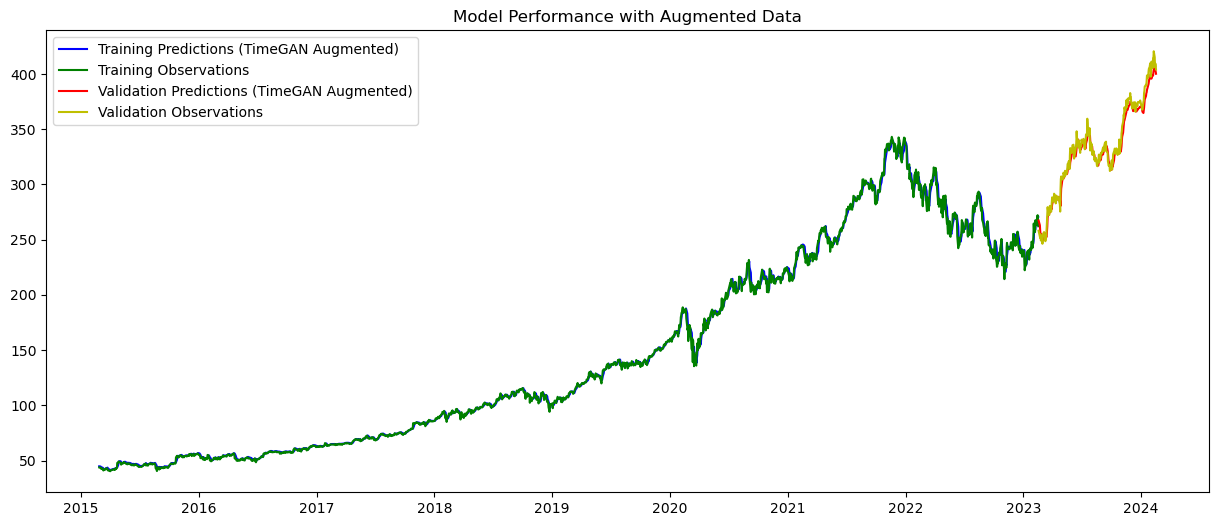

In [ ]:
# Check the performance of the LSTM model with AUGMENTED DATA
train_predictions_aug_norm = model_augmented.predict(X_train_norm)
val_predictions_aug_norm = model_augmented.predict(X_val_norm)


train_predictions__aug_orig = y_scaler.inverse_transform(train_predictions_aug_norm.reshape(-1, 1))
val__predictions__aug_orig = y_scaler.inverse_transform(val_predictions_aug_norm.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions__aug_orig, 'b', label='Training Predictions (TimeGAN Augmented)')
plt.plot(dates_train, y_train_orig, 'g', label='Training Observations')
plt.plot(dates_val, val__predictions__aug_orig, 'r', label='Validation Predictions (TimeGAN Augmented)')
plt.plot(dates_val, y_val_orig, 'y', label='Validation Observations')
plt.legend()
plt.title('Model Performance with Augmented Data')
plt.show()

# COMPARISON and PERFORMANCE ASSESSMENT

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


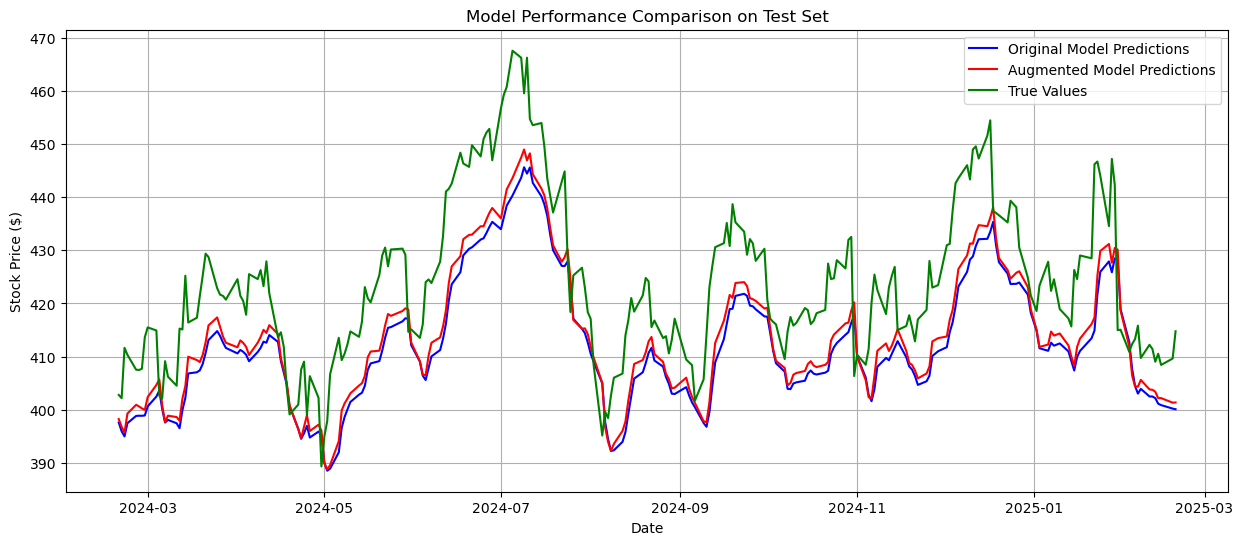

In [ ]:
# 1. make predictions on the same test set using the two different LSTM
test_predictions_norm = model.predict(X_test_norm)  # LSTM trained on original training dataset
test_predictions_aug_norm = model_augmented.predict(X_test_norm) # LSTM trained on augmented training dataset

test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1))
test_predictions__aug_orig = y_scaler.inverse_transform(test_predictions_aug_norm.reshape(-1, 1))

# 2. Comparison plot
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions_orig, 'b', label='Original Model Predictions')
plt.plot(dates_test, test_predictions__aug_orig, 'r', label='Augmented Model Predictions')
plt.plot(dates_test, y_test_orig, 'g', label='True Values')
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [291]:
#Original model performance
mae_original = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_original = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

#Performance of model with augmented data
mae_augmented = mean_absolute_error(y_test_orig, test_predictions__aug_orig)
rmse_augmented = np.sqrt(mean_squared_error(y_test_orig, test_predictions__aug_orig))

print("\nTest Set Performance Metrics:")
print("\nOriginal Model:")
print(f"MAE: ${mae_original:.2f}")
print(f"RMSE: ${rmse_original:.2f}")

print("\nAugmented Model:")
print(f"MAE: ${mae_augmented:.2f}")
print(f"RMSE: ${rmse_augmented:.2f}")

#Improvement thanks to the synthetic data
mae_improvement = ((mae_original - mae_augmented) / mae_original) * 100
rmse_improvement = ((rmse_original - rmse_augmented) / rmse_original) * 100

print(f"\nImprovement with Data Augmentation:")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


Test Set Performance Metrics:

Original Model:
MAE: $12.10
RMSE: $13.50

Augmented Model:
MAE: $10.55
RMSE: $11.85

Improvement with Data Augmentation:
MAE Improvement: 12.79%
RMSE Improvement: 12.21%
